In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import Model
# from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from tensorflow.keras.models import load_model

In [8]:
RATED_FOOD_PATH = 'H:\Project\Bangkit Product ML\menu-recommendation\menu-recommendation\csv_dataset\Exported Rated Food 07-06-2021 16-35-04.csv'
RATING_PATH = 'H:\Project\Bangkit Product ML\menu-recommendation\menu-recommendation\csv_dataset\Exported Rating 07-06-2021 16-35-04.csv'
USER_PATH = 'H:\Project\Bangkit Product ML\menu-recommendation\menu-recommendation\csv_dataset\Exported User 07-06-2021 16-35-04.csv'

**1. Read Exported CSV From DB**

In [9]:
food_df = pd.read_csv(RATED_FOOD_PATH)
rating = pd.read_csv(RATING_PATH)
user_df = pd.read_csv(USER_PATH)

In [10]:
food_df.head()

,food_id,food_code,name,category,type,calories,protein,carbs,fat,fiber,sugar,vitamin_a,vitamin_b6,vitamin_b12,vitamin_c,vitamin_d,vitamin_e
0,8,11432000,"Yogurt, low fat milk, fruit",Yogurt,Food,89.0,4.66,14.46,1.37,0.1,12.01,12.0,0.046,0.49,1.8,1.2,0.04
1,13,11435100,"Yogurt, Greek, with oats",Yogurt,Food,160.0,8.90,22.38,4.29,1.9,12.07,88.0,0.077,0.53,0.1,0.7,0.24
2,15,11446000,"Yogurt parfait, low fat, with fruit",Yogurt,Food,84.0,3.36,15.86,1.01,1.1,11.68,30.0,0.233,0.88,14.3,1.2,0.25
3,16,14710200,"Beer cheese soup, made with milk",Soups,Food,192.0,6.19,6.52,15.43,0.3,0.80,182.0,0.037,0.26,0.3,0.3,0.45
4,23,26109133,"Cod, coated, baked or broiled, no added fat",Fish,Food,137.0,17.32,13.10,1.16,0.6,1.15,9.0,0.121,1.81,0.0,0.6,0.54


In [11]:
rating.head()

,rating_id,user_id,food_id,food_code,rating
0,3,1,120,27445220,2
1,4,1,176,32105210,2
2,5,1,184,41311030,3
3,6,1,193,42401100,2
4,7,4,365,42403010,4


In [12]:
user_df.head()

,user_id,name,username,email
0,1,Gugun Andriawan,username0,username0@ayohealthy.id
1,4,Mikey,username4,username4@ayohealthy.id
2,5,BrutusSmith,username5,username5@ayohealthy.id
3,6,Guts,username6,username6@ayohealthy.id
4,9,Imam Septian,username9,username9@ayohealthy.id


In [13]:
rating.dropna(inplace=True)

In [14]:
rating.isna().sum()

rating_id    0
user_id      0
food_id      0
food_code    0
rating       0
dtype: int64

**2. Encode User_ID and Rating using LabelEncoder()**

In [15]:
user_enc = LabelEncoder()
rating['User_ID'] = user_enc.fit_transform(rating['user_id'])

food_enc = LabelEncoder()
rating['Food_ID'] = food_enc.fit_transform(rating['food_code'])
rating.head()

,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID
0,3,1,120,27445220,2,0,40
1,4,1,176,32105210,2,0,59
2,5,1,184,41311030,3,0,65
3,6,1,193,42401100,2,0,69
4,7,4,365,42403010,4,1,70


In [16]:
userid_nunique = rating['User_ID'].nunique()
food_unique = rating['Food_ID'].nunique()

print('User_id total unique:', userid_nunique)
print('Food ID total unique:', food_unique)

User_id total unique: 138
Food ID total unique: 140


**3. Build Tensorflow Recommendation Model**

In [19]:
def RecommenderV2(n_users, n_food, n_dim):
    
    # User Embedding
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Food Rating Embedding
    food = Input(shape=(1,))
    M = Embedding(n_food, n_dim)(food)
    M = Flatten()(M)
    

    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dense_2 = Dense(64, activation='relu')(dense_1)
    final = Dense(1)(dense_2)
    
    model = Model(inputs=[user, food], outputs=final)
    
    model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
    
    return model

**4. Model Structure**

In [20]:
from tensorflow.keras.utils import plot_model

# Assuming your model is named RecommenderV2
model = RecommenderV2(userid_nunique, food_unique, 32)

# Plot the model and display the plot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plot.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        4416        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        4480        ['input_2[0][0]']                
                                                                                              

**5. Split Training and Validation Data**

In [23]:
from sklearn.model_selection import train_test_split

X = rating.drop(['rating'], axis=1)
y = rating['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify=y,
                                                  random_state=87)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((568, 6), (143, 6), (568,), (143,))

**6. Setting Training Callback**

In [24]:
checkpoint = ModelCheckpoint('sysrec.h5', monitor='val_loss', verbose=0, save_best_only=True)
val_loss_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

**7. Train the Data**

In [25]:
history = model.fit(x=[X_train['User_ID'], X_train['Food_ID']],
                    y=y_train,
                    batch_size=64,
                    epochs=100,
                    verbose=1,
                    validation_data=([X_val['User_ID'], X_val['Food_ID']], y_val),
                    callbacks=[val_loss_cb,checkpoint])

Epoch 1/100
9/9 [==============================] - 4s 44ms/step - loss: 11.7081 - val_loss: 11.0994
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 10.3420 - val_loss: 9.3097
Epoch 3/100
9/9 [==============================] - 0s 31ms/step - loss: 7.9983 - val_loss: 6.3415
Epoch 4/100
9/9 [==============================] - 0s 33ms/step - loss: 4.5636 - val_loss: 2.7304
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 2.1375 - val_loss: 1.9253
Epoch 6/100
9/9 [==============================] - 0s 31ms/step - loss: 1.9291 - val_loss: 1.6913
Epoch 7/100
9/9 [==============================] - 0s 12ms/step - loss: 1.4466 - val_loss: 1.7225
Epoch 8/100
9/9 [==============================] - 0s 13ms/step - loss: 1.3558 - val_loss: 1.7080
Epoch 9/100
9/9 [==============================] - 0s 13ms/step - loss: 1.2178 - val_loss: 1.7713


**8. Plot Model Training and Validation Result**

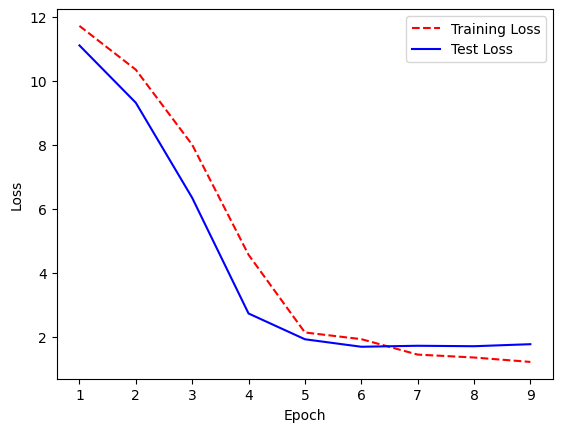

In [26]:
import matplotlib.pyplot as plt
training_loss2 = history.history['loss']
test_loss2 = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**9. Recommendation DF Function**

In [28]:
def make_pred(user_id, food_id, model):
    return model.predict([np.array([user_id]), np.array([food_id])])[0][0]

In [29]:
def get_topN_rec(user_id, model):
    user_ratings = rating[rating['user_id'] == user_id]
    converted_id = rating[rating['user_id'] == user_id].head(1).User_ID.tolist()

    #remove food that user already rated
    recommendation = rating[~rating['Food_ID'].isin(user_ratings['Food_ID'])][['Food_ID','food_code']].drop_duplicates()
    #predict user rating for every user non rated food
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(converted_id[0], x['Food_ID'], model), axis=1)
    
    #create DF user non rated food sorted by rating prediction descending
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(food_df[['food_code', 'name','type','category']],on='food_code')
    return final_rec.sort_values('rating_predict', ascending=False)[['name','food_code', 'rating_predict','type','category']]

**10. Try Predict Every User Non Rated Food for One User**

In [34]:
model_title = 'sysrec.h5'
model = load_model(model_title)

USER_ID = 23
print('USER ID: {} RATED FOOD'.format(USER_ID))
# food_df.loc[food_df['Food_ID'].isin(rating.loc[rating['User_ID']==2]['Food_ID'].to_list())]
rating.loc[rating['user_id']==USER_ID].merge(food_df[['food_code', 'name','category','type']],on='food_code').sort_values(by='rating',ascending=False)

USER ID: 23 RATED FOOD


,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID,name,category,type
0,79,23,96,27243100,5,17,31,Biryani with chicken,Rice mixed dishes,Food
1,80,23,96,27243100,5,17,31,Biryani with chicken,Rice mixed dishes,Food
5,84,23,400,73105010,5,17,110,"Carrot juice, 100%",Fruit drinks,Beverage
2,81,23,181,41203030,4,17,62,Black bean salad,Bean,Food
6,85,23,296,75608100,4,17,123,"Onion soup, French",Soups,Food
4,83,23,270,72202010,3,17,106,Broccoli casserole with noodles,Vegetable dishes,Food
3,82,23,399,73105000,2,17,109,Beet juice,Fruit drinks,Beverage


In [35]:
print('RECOMENDATION FOR USER ID : ',USER_ID)
rec_result = get_topN_rec(USER_ID, model)
rec_result

RECOMENDATION FOR USER ID :  23
1/1 [==============================] - 0s 29ms/step


,name,food_code,rating_predict,type,category
0,"Chocolate milk, ready to drink, low fat",11511400,4.171311,Beverage,Milk
1,"Soy milk, nonfat, chocolate",11321200,4.122975,Beverage,Milk substitutes
2,"Vegetable and fruit juice drink, with high vit...",92550400,4.094396,Beverage,Diet drinks
3,"Apple juice, 100%",64104010,4.084154,Beverage,Fruit drinks
4,"Tuna salad sandwich, on bread",27550720,4.068480,Food,Sandwiches
...,...,...,...,...,...
129,Shrimp salad,27450070,2.784500,Food,Seafood mixed dishes
130,"Dukboki or Tteokbokki, Korean",58150520,2.743958,Food,Rice mixed dishes
131,"Coconut water, sweetened",42404010,2.667098,Beverage,Fruit drinks
132,"Codfish salad, Puerto Rican style, Serenata",27451070,2.547277,Food,Seafood mixed dishes


**11. Creating Recommendation For All User**

In [37]:
# create zeros DF that index representing user_id and columns represending food_code
zeros_df = pd.DataFrame(0,index=sorted(rating['user_id'].unique()),columns=food_df['food_code'].tolist())
zeros_df

,11432000,11435100,11446000,14710200,26109133,26109143,26127123,26137123,26153122,26205160,...,92550400,92582100,92611100,92613010,92613510,94220215,95106000,95110020,95312400,95312410
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#create dictionary for every data to labelencoder data
user_dict = {}
food_dict = {}
for index, row in rating.iterrows():
  if(row['user_id'] not in user_dict):
    user_dict[row['user_id']] = row['User_ID']

  if(row['food_code'] not in food_dict):
    food_dict[row['food_code']] = row['Food_ID']

In [39]:
total_user = len(zeros_df)
step_loop = 0
for index, row in zeros_df.iterrows():
  arr_rated = rating.loc[rating['user_id']==index,'food_code'].tolist()
  for rate in arr_rated:
    zeros_df.loc[index,rate]=rating.loc[(rating['user_id']==index)&(rating['food_code']==rate),'rating'].tolist()[0]

  not_rated = food_df.loc[(~food_df['food_code'].isin(arr_rated)),'food_code'].tolist()
  for rate in not_rated:
    try:

      zeros_df.loc[index,rate]=model.predict([np.array([user_dict[index]]), np.array([food_dict[rate]])])[0][0]
    except:
      zeros_df.loc[index,rate]=0

  step_loop+=1
  print('Filing Row {} / {}'.format(step_loop,total_user))
    

1/1 [==============================] - 0s 27ms/step
Filing Row 1 / 138
1/1 [==============================] - 0s 27ms/step
Filing Row 2 / 138
1/1 [==============================] - 0s 28ms/step
Filing Row 3 / 138
1/1 [==============================] - 0s 27ms/step
Filing Row 4 / 138
1/1 [==============================] - 0s 28ms/step
Filing Row 5 / 138
1/1 [==============================] - 0s 25ms/step
Filing Row 6 / 138
1/1 [==============================] - 0s 26ms/step
Filing Row 7 / 138
1/1 [==============================] - 0s 29ms/step
Filing Row 8 / 138
1/1 [==============================] - 0s 27ms/step
Filing Row 9 / 138
1/1 [==============================] - 0s 26ms/step
Filing Row 10 / 138
1/1 [==============================] - 0s 26ms/step
Filing Row 11 / 138
1/1 [==============================] - 0s 27ms/step
Filing Row 12 / 138
1/1 [==============================] - 0s 31ms/step
Filing Row 13 / 138
1/1 [==============================] - 0s 27ms/step
Filing Row 14 / 138
1

In [27]:
zeros_df

,11432000,11435100,11446000,14710200,26109133,26109143,26127123,26137123,26153122,26205160,...,92550400,92582100,92611100,92613010,92613510,94220215,95106000,95110020,95312400,95312410
1,2.692970,2.339809,2.427089,2.987195,2.332849,2.588544,2.528049,2.392405,2.435431,2.477841,...,2.784610,2.783447,1.589948,2.212843,2.561419,2.478591,2.311187,2.323420,2.541018,2.367846
4,3.378472,3.037703,3.141467,3.701842,3.024034,3.315576,3.240636,3.097558,3.149899,3.191127,...,3.483700,3.469026,2.259689,2.927508,3.288370,3.202382,3.008510,3.005855,3.251544,3.073089
5,3.153230,2.818445,2.908787,3.477720,2.809633,3.072681,3.001192,2.860878,2.921151,2.958529,...,3.262174,3.257515,2.027239,2.682773,3.028263,2.957795,2.784161,2.783939,3.027955,2.835053
6,2.763573,2.440706,2.519318,3.084630,2.409079,2.681221,2.627286,2.484972,2.529111,2.582637,...,2.873531,2.874768,1.677362,2.311488,2.644010,2.582509,2.394809,2.409469,2.626082,2.455036
9,3.744065,3.392233,3.496675,4.055060,3.373998,3.670036,3.584831,3.452385,3.494440,3.541353,...,3.832685,3.829749,2.618541,3.285973,1.000000,3.554090,3.363275,3.373880,3.603107,3.429971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,3.697583,3.349464,3.451038,4.003129,3.325703,3.624915,3.535415,3.404642,3.442664,3.000000,...,3.785021,3.778342,2.587940,3.238024,3.585982,3.505359,5.000000,3.337399,3.549723,3.383596
149,3.364474,3.020814,3.114241,3.000000,3.004481,3.288163,3.201825,3.074761,3.114199,3.158778,...,3.456929,3.456261,2.252616,2.901216,3.257399,3.167014,2.986528,3.004269,3.230128,3.050395
150,5.000000,3.222996,4.000000,3.865554,3.199120,3.481870,3.408670,3.283441,3.314157,3.371460,...,3.665751,3.664302,2.452756,3.102136,3.443680,3.373649,3.186162,3.205302,3.428508,3.258938
151,3.126723,2.805795,2.880569,3.456211,3.000000,3.056858,2.988358,2.836407,2.882517,2.936184,...,3.236228,3.245763,2.027415,2.662078,3.016824,2.942877,2.757597,2.765978,2.983926,2.827235


In [29]:
food_name_dict = {}
for index, row in food_df.iterrows():
    if(row['food_code'] not in food_name_dict):
        food_name_dict[row['food_code']] = row['name']

**12. Give Recommendation to One User**

In [52]:
USER_ID = 150
food_code_arr = []
name_arr = []
prediction_arr = []
user_rated_food_code = rating.loc[rating['user_id']==USER_ID,'food_code'].tolist()
for key, value in zeros_df.loc[int(USER_ID)].items():
  if(int(key) not in user_rated_food_code):
    food_code_arr.append(int(key))
    name_arr.append(food_name_dict[int(key)])
    prediction_arr.append(value)

             

In [53]:
print('Recommendation for user id : {}'.format(USER_ID))
rating.loc[rating['user_id']==USER_ID].merge(food_df[['food_code', 'name','category','type']],on='food_code').sort_values(by='rating',ascending=False)

Recommendation for user id : 150


,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID,name,category,type
0,741,150,8,11432000,5,135,9,"Yogurt, low fat milk, fruit",Yogurt,Food
1,742,150,15,11446000,4,135,11,"Yogurt parfait, low fat, with fruit",Yogurt,Food
3,744,150,341,11513370,4,135,14,"Chocolate milk, made from reduced sugar mix wi...",Milk,Beverage
4,745,150,93,27150410,4,135,28,Shrimp teriyaki,Stir-fry and soy-based sauce mixtures,Food
5,746,150,291,75439500,4,135,121,"Chow mein or chop suey, meatless, no noodles",Stir-fry and soy-based sauce mixtures,Food
2,743,150,358,11519205,3,135,16,"Strawberry milk, fat free",Milk,Beverage


In [54]:
recommendation_columns = {'food_code': food_code_arr,
                                  'name': name_arr,
                                  'predicted_rating': prediction_arr,
                                  }

rec_for_user = pd.DataFrame(data=recommendation_columns)   

In [55]:
rec_for_user

,food_code,name,predicted_rating
0,11435100,"Yogurt, Greek, with oats",3.222996
1,14710200,"Beer cheese soup, made with milk",3.865554
2,26109133,"Cod, coated, baked or broiled, no added fat",3.199120
3,26109143,"Cod, coated, fried, no added fat",3.481870
4,26127123,"Perch, baked or broiled, no added fat",3.408670
...,...,...,...
129,94220215,"Water, bottled, flavored, sugar free (Glaceau ...",3.373649
130,95106000,"Nutritional drink or shake, ready-to-drink (Mu...",3.186162
131,95110020,"Nutritional drink or shake, high protein, read...",3.205302
132,95312400,"Energy drink, low calorie (Monster)",3.428508


In [57]:
# SORTED RATING FOR ONE USER
rec_for_user.sort_values(
            by='predicted_rating', ascending=False)

,food_code,name,predicted_rating
22,27416400,Stir fried beef and vegetables in soy sauce,3.951838
71,71801100,Potato and cheese soup,3.943426
1,14710200,"Beer cheese soup, made with milk",3.865554
21,27415140,Hunan beef,3.806448
32,27550720,"Tuna salad sandwich, on bread",3.759427
...,...,...,...
112,64133100,"Watermelon juice, 100%",2.539422
39,28355310,Oyster stew,2.525016
126,92611100,Oatmeal beverage with milk,2.452756
67,58200250,"Wrap sandwich, filled with vegetables",2.407209


In [40]:
zeros_df.to_csv('TF Recommendation DF.csv', index=False)

**13. Save Predicted DF to CSV**

In [ ]:
zeros_df.to_csv('TF Recommendation Index.csv', index=True)